In [1]:
import pandas as pd

df = pd.read_csv('data/preprocessed_data.csv')

In [2]:
df['price'].describe()

count    1.240305e+06
mean     1.284586e+01
std      8.291757e-01
min      8.646641e+00
25%      1.236735e+01
50%      1.283468e+01
75%      1.330452e+01
max      1.892146e+01
Name: price, dtype: float64

In [3]:
less_than_25 = df['price'].describe()['25%']
less_than_50 = df['price'].describe()['50%']
less_than_75 = df['price'].describe()['75%']

In [4]:
def data_price_labeling(price):
    if price <= less_than_25:
        return 'less than 25%'
    elif less_than_25 < price <= less_than_50:
        return 'between 25% and 50%'
    elif less_than_50 < price <= less_than_75:
        return 'between 50% and 75%'
    else:
        return 'above 75%'

In [5]:
df2 = df.copy()

df2.loc[:, 'class'] = df2.apply(lambda sample: data_price_labeling(sample['price']), axis=1)

In [40]:
from sklearn.neighbors import NearestNeighbors

def select_top_knn(data_subset, n_neighbors=10):

    nbrs = NearestNeighbors(n_neighbors=n_neighbors + 1, metric='euclidean')
    nbrs.fit(data_subset)

    distances, indices = nbrs.kneighbors(data_subset)

    all_indices = indices[:, 1:].flatten()
    all_distances = distances[:, 1:].flatten()

    combined = list(zip(all_distances, all_indices))
    combined = sorted(combined, key=lambda x: x[0])

    selected_indices = []
    for _, idx in combined:
        if idx not in selected_indices:
            selected_indices.append(idx)
        if len(selected_indices) == n_neighbors:
            break

    return data_subset.iloc[selected_indices]

In [25]:
data_less_25 = df2[df2['class'] == 'less than 25%'].sample(n=1000, random_state=42).drop('class', axis=1)
data_25_50 = df2[df2['class'] == 'between 25% and 50%'].sample(n=1000, random_state=42).drop('class', axis=1)
data_50_75 = df2[df2['class'] == 'between 50% and 75%'].sample(n=1000, random_state=42).drop('class', axis=1)
data_above_75 = df2[df2['class'] == 'above 75%'].sample(n=1000, random_state=42).drop('class', axis=1)

In [26]:
top_less_25 = select_top_knn(data_less_25, n_neighbors=10)
top_25_50 = select_top_knn(data_25_50, n_neighbors=10)
top_50_75 = select_top_knn(data_50_75, n_neighbors=10)
top_above_75 = select_top_knn(data_above_75, n_neighbors=10)

In [27]:
def create_graph(dataset):
    graph = [{'index': 0, 'weight': 0, 'links': [], 'centrality': 0} for _ in range(10)]

    for i in range(len(dataset)):
        current_data = dataset.iloc[i]
        graph[i]['index'] = dataset.index[i]

        for j in range(i + 1, len(dataset)):
            compare_by_data = dataset.iloc[j]
            similarities = (current_data == compare_by_data).sum()
            if similarities != 0:
                graph[i]['links'].append({'index': dataset.index[j], 'similarities': similarities})
                graph[i]['weight'] += similarities

    return graph

In [28]:
graph_less_25 = create_graph(top_less_25)
graph_25_50 = create_graph(top_25_50)
graph_50_75 = create_graph(top_50_75)
graph_above_75 = create_graph(top_above_75)

In [29]:
def malatya_centrality(data, graph):
    tmp_graph = graph.copy()
    tmp_graph.insert(0, {'index': 0, 'weight': 0, 'links': [], 'centrality': 0})

    current_data = data

    for i in range(1, len(tmp_graph)):
        compare_by_data = x.loc[tmp_graph[i]['index']]
        similarities = (current_data == compare_by_data).sum()
        if similarities != 0:
            tmp_graph[0]['links'].append({'index': tmp_graph[i]['index'], 'similarities': similarities})
            tmp_graph[0]['weight'] += similarities

    for i in range(len(tmp_graph) - 1, -1, -1):
        top = 0
        for j in range(i - 1, -1, -1):
            linked_nodes = [link for link in tmp_graph[j]['links'] if link['index'] == tmp_graph[i]['index']]
            if linked_nodes:
                top += linked_nodes[0]['similarities']
        tmp_graph[i]['weight'] += top

    for i in range(len(tmp_graph) - 1, -1, -1):
        centrality = 0
        if i == 0:
            for link in tmp_graph[i]['links']:
                centrality += (
                        tmp_graph[i]['weight'] /
                        next((node for node in tmp_graph if node['index'] == link['index']), None)[
                            'weight'])
                tmp_graph[i]['centrality'] = centrality
        for j in range(i - 1, -1, -1):
            for link in tmp_graph[j]['links']:
                if link['index'] == tmp_graph[i]['index']:
                    centrality += (tmp_graph[i]['weight'] / tmp_graph[j]['weight'])
                    tmp_graph[i]['centrality'] = centrality

    return tmp_graph[0]['centrality'], tmp_graph

In [30]:
def class_predict(data):
    c1, _ = malatya_centrality(data, graph_less_25)
    c2, _ = malatya_centrality(data, graph_25_50)
    c3, _ = malatya_centrality(data, graph_50_75)
    c4, _ = malatya_centrality(data, graph_above_75)

    centrality_list = [c1, c2, c3, c4]
    graph_index = centrality_list.index(max(centrality_list))

    if graph_index == 0:
        return 'less than 25%'
    if graph_index == 1:
        return 'between 25% and 50%'
    if graph_index == 2:
        return 'between 50% and 75%'
    else:
        return 'above 75%'

In [31]:
import networkx as nx
import matplotlib.pyplot as plt


def plot_graph(data):
    c1, g1 = malatya_centrality(data, graph_less_25)
    c2, g2 = malatya_centrality(data, graph_25_50)
    c3, g3 = malatya_centrality(data, graph_50_75)
    c4, g4 = malatya_centrality(data, graph_above_75)

    centrality_list = [c1, c2, c3, c4]
    graph_list = [g1, g2, g3, g4]
    graph_index = centrality_list.index(max(centrality_list))

    if graph_index == 0:
        belong_graph = {'class': 'less than 25%', 'graph': g1, 'table': top_less_25}
    elif graph_index == 1:
        belong_graph = {'class': 'between 25% and 50%', 'graph': g2, 'table': top_25_50}
    elif graph_index == 2:
        belong_graph = {'class': 'between 50% and 75%', 'graph': g3, 'table': top_50_75}
    else:
        belong_graph = {'class': 'above 75%', 'graph': g4, 'table': top_above_75}

    for graph in graph_list:
        G = nx.Graph()

        node_list = [node for node in graph]

        G.add_nodes_from([node['index'] for node in node_list])

        edges = []

        for node in node_list:
            for link in node['links']:
                if link['similarities'] != 0:
                    edges.append((node['index'], link['index'], link['similarities']))

        G.add_edges_from([(u, v, {"label": label}) for u, v, label in edges])

        node_colors = ['yellow' if node == graph[0]['index'] else 'skyblue' for node in G.nodes]

        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=800)

        edge_labels = nx.get_edge_attributes(G, "label")
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")

        plt.show()
    return belong_graph


In [32]:
from sklearn.model_selection import train_test_split

x = df2.drop('class', axis=1)
y = df2['class']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

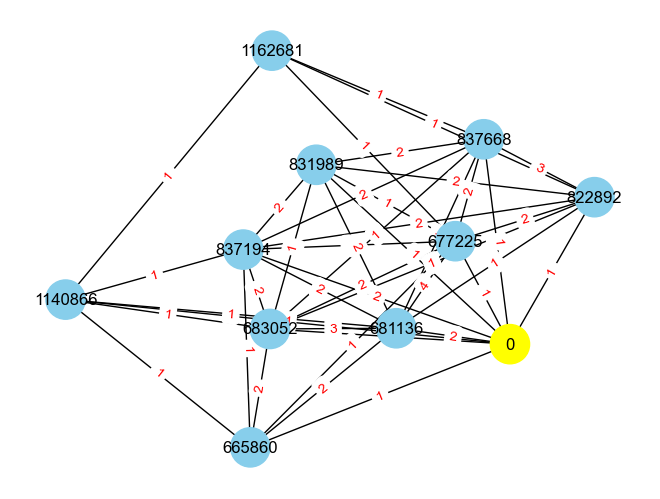

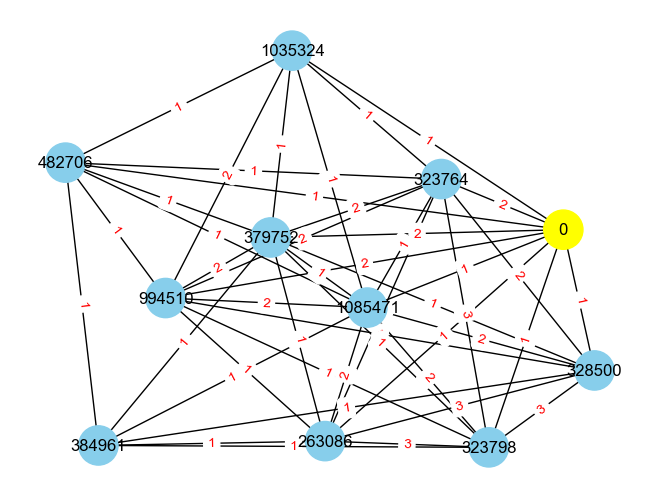

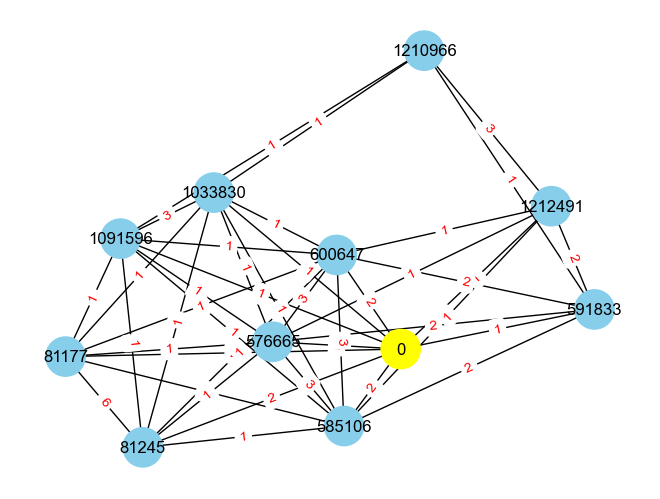

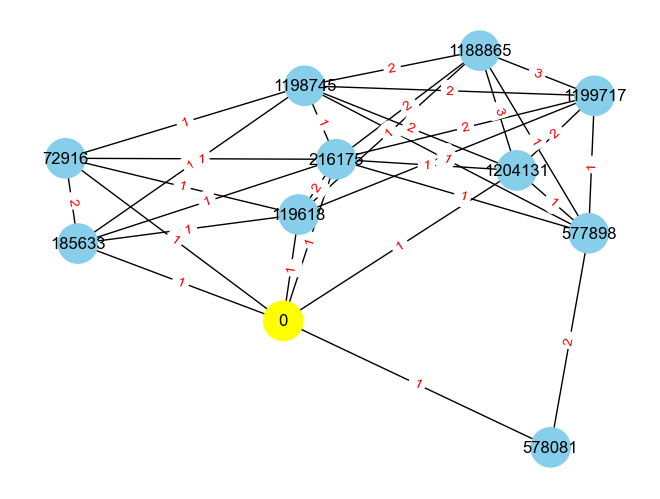

In [33]:
selected_graph = plot_graph(X_test.iloc[0])

In [34]:
selected_graph['class']

'between 50% and 75%'

In [35]:
centrality_table = [x['centrality'] for x in selected_graph['graph']]
index_table = [x['index'] for x in selected_graph['graph']]
centrality_table = pd.DataFrame({'centrality': centrality_table}, index=index_table).sort_index()

In [36]:
X_test_row = X_test.iloc[0].to_frame().T
X_test_row.index = [0]
pd.concat([selected_graph['table'], X_test_row], ignore_index=False).join(centrality_table).sort_index()

,price,bed,bath,acre_lot,street,zip_code,house_size,state_average_price,city_average_price,centrality
0,13.199326,1.386294,1.098612,6.341347,1196324.0,92591.0,4.688868,13.902057,13.633308,10.709402
81177,13.151730,1.098612,1.098612,8.568251,402818.0,90706.0,4.603369,13.902057,13.748845,0.928571
81245,13.120363,1.098612,1.098612,8.568251,402817.0,90706.0,4.497919,13.902057,13.748845,1.928571
576665,13.217494,1.386294,1.098612,6.959573,1668247.0,1915.0,4.996401,13.503539,13.394653,9.045788
585106,13.304520,1.386294,1.098612,6.920390,1105734.0,1749.0,4.998225,13.503539,13.237554,10.045788
591833,13.091906,1.386294,1.386294,7.551200,1105473.0,1612.0,5.143300,13.503539,13.007411,5.492063
600647,13.215856,1.386294,1.098612,6.187490,1668347.0,1801.0,5.242752,13.503539,13.396856,8.045788
1033830,12.854460,1.609438,1.098612,6.592270,1151603.0,75087.0,5.206915,13.021476,12.941046,3.252747
1091596,13.122365,1.609438,1.098612,8.189440,1151664.0,75068.0,5.936110,13.021476,13.133811,2.252747
1210966,13.122165,1.609438,1.386294,6.005579,193146.0,98682.0,5.097608,13.494803,13.214970,1.200000


In [37]:
y_pred = pd.DataFrame(
    {'class': [class_predict(data_point) for data_point in X_test.head(200).itertuples(index=False)]})

In [38]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test.head(200), y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.395


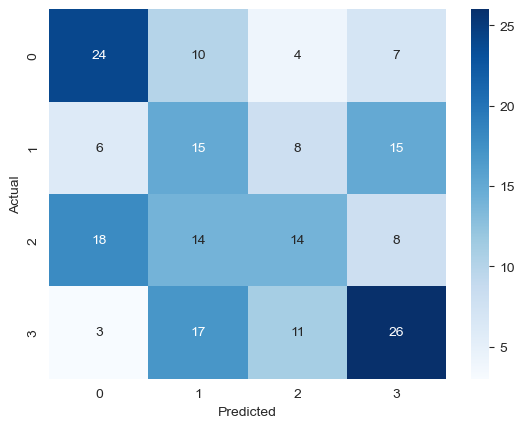

In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test.head(200), y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()